## Basic Guassian Process with a particular surrogate function and probability of improvement acqusition

This is based on: https://machinelearningmastery.com/what-is-bayesian-optimization/

In [199]:

# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
import numpy
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

### Surrogate function
* Conditional probability of an objective function for the available data.
* Guassian process is a famous process, joint probab distribution over the variables. 
* GP regression model:  GP model is the kernel. This controls the shape of the function at specific points based on distance measures between actual data observations. 





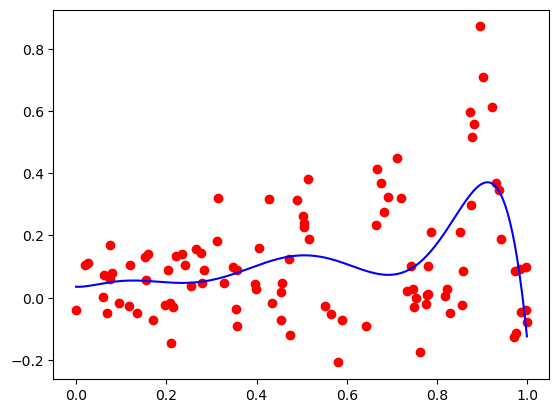

In [200]:
# objective function
def objective(x, noise=0.1):
 noise = normal(loc=0, scale=noise)
 return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)


# plot real observations vs surrogate function
def plot(X, y, model):
    pyplot.scatter(X, y, color='red')
    Xsamples = arange(0, 1, 0.001).reshape(-1, 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples, color='blue')
    pyplot.show()

# sample the domain sparsely with noise
X = random(100).reshape(-1, 1)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)


### Acquistion fuunciton
* Surrogate function is used to test a range of candidates samplies in a domain.
* Search strategy is the first step to navigate the domain in response. Random and grid sample strategy are base searching tech. BFGS is a local search startegy.
* Aquisition function to interpret and score the response function.
### Acquistion startegies
* It is responsible for scoring or estimating that chosen sample is worth evaluating with the real objective function.
* Types: Probability of Imporvement (PI), Expected Improved (EI) and Lower Confidence Bound (LCB).
* PI = cdf((mu-best_mu)/stdev)


In [201]:
# Probability of Improvement acquisition function
def acquisition(X, Xsamples, model):
    # Calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # Calculate mean and std via the surrogate function
    mu, std = surrogate(model, Xsamples)
    # Ensure no division by zero in calculation
    std = numpy.where(std == 0, 1e-9, std)
    # Calculate the Probability of Improvement
    probs = norm.cdf((mu - best) / std)
    return probs

# Function to optimize the acquisition function
def opt_acquisition(X, y, model):
    # Generate random samples
    Xsamples = random(100).reshape(-1, 1)
    # Calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # Locate the index of the largest score
    ix = argmax(scores)
    return Xsamples[ix, 0]

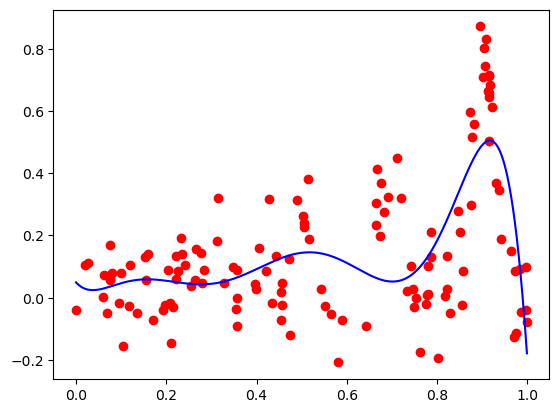

Best Result: x=0.895, y=0.872


In [202]:
# Perform Bayesian Optimization
for i in range(30):
    # Select the next point to sample
    x = opt_acquisition(X, y, model)
    # Sample the point
    actual = objective(x)
    # Add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # Update the model
    model.fit(X, y)

# Plot all samples and the final surrogate function
plot(X, y, model)

# Output the best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix][0], y[ix][0]))